In [68]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_algorithms import NumPyMinimumEigensolver

from algo.utils import (
    tfim_hamiltonian,
    circuit_HVA_TIFM,
    expectation_loss_grad,
    interp_matrix,
    optimal_interp_points
)

cite: Exploring Entanglement and Optimization within the Hamiltonian Variational
Ansatz

## Transverse-field Ising model

The TFIM is a paradigmatic model for studies of quantum magnetism. The Hamiltonian for the 1 D chain is
given by

$$
H_{\mathrm{TFIM}}=-\sum_{i=1}^N\left[\sigma_i^z \sigma_{i+1}^z+g \sigma_i^x\right]=H_{z z}+g H_x,
$$

with $H_{z z}=-\sum_{i=1}^N \sigma_i^z \sigma_{i+1}^z$ and $H_x=-\sum_{i=1}^N \sigma_i^x$, where we assume that $g>0$ and use periodic boundary conditions $\sigma_{N+1}^z \equiv \sigma_1^z$. Here, $\sigma_i^\alpha$ corresponds to a Pauli matrix $\alpha=x, y, z$ acting on a site $i$, where the Pauli matrices are defined as follows:

$$
\sigma_x \equiv\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right), \quad \sigma_y \equiv\left(\begin{array}{cc}
0 & -i \\
i & 0
\end{array}\right), \quad \sigma_z \equiv\left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right) .
$$


In [69]:
# global
num_q = 4
layer = 2
num_p = layer * 2

tfim_op = tfim_hamiltonian(num_q, J=-1.0, g=-0.5, bc='periodic')
print(tfim_op)

SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'ZIIZ', 'XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[-1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j])


In [70]:
# Directly use NumPyMinimumEigensolver
eigensolver = NumPyMinimumEigensolver()
result = eigensolver.compute_minimum_eigenvalue(operator=tfim_op)

# Extract the ground state energy and ground state vector
ground_energy = result.eigenvalue.real
# ground_state = result.eigenstate  # This is a statevector

print(f"Ground state energy = {ground_energy}")
# print(f"Ground state vector = {ground_state}")


Ground state energy = -4.271558410139716


In [71]:
from qiskit.quantum_info import random_unitary
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.primitives import Estimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient

U_rands = [random_unitary(2**num_q) for _ in range(100)]

# def circuit_HVA_TIFM(num_q: int, layer: int):
#     """
#     Construct a parameterized HVA (Hamiltonian Variational Ansatz) quantum circuit
#     for the Transverse Field Ising Model (TFIM), along with its parameter vector.
    
#     Parameters:
#         num_q (int): Number of qubits
#         layer (int): Number of HVA layers (depth of the variational circuit)
    
#     Returns:
#         param_qc (QuantumCircuit): The parameterized quantum circuit
#         theta (ParameterVector): The parameter vector
#     """
#     num_p = 1 * layer
#     theta = ParameterVector("θ", num_p)
    
#     circ = QuantumCircuit(num_q)
    
#     circ.append(U_rands[0],list(range(0,num_q)))    

#     # # Initial layer: apply Hadamard gates to all qubits
#     # for j in range(num_q):
#     #     circ.h(j)
    
#     # Variational layers
#     for i in range(layer):
#         # # ZZ interaction terms (ring topology assumed)
#         # for j in range(num_q):
#         #     circ.rzz(theta[2 * i], j, (j + 1) % num_q)
#         # Transverse field X terms
#         for j in range(num_q):
#             circ.rx(theta[i], j)

#     # # —— 方法1：每个 qubit 加一个随机 Rx
#     # for j in range(num_q):
#     #     rand_angle = np.random.rand() * 2 * np.pi
#     #     circ.rx(rand_angle, j)

#     # # —— 方法2：每个 qubit 加一个随机 2×2 幺正门
#     #     for i in range(num_q):
#     #         U = random_unitary(2)      # 生成一个 2×2 随机幺正矩阵
#     #         circ.append(U, [i])

#         # for i in range(num_q):
#         circ.append(U_rands[i+1],list(range(0,num_q)))

#     return circ, theta


def circuit_HVA_TIFM(num_q: int, layer: int):
    """
    Construct a parameterized HVA (Hamiltonian Variational Ansatz) quantum circuit
    for the Transverse Field Ising Model (TFIM), along with its parameter vector.
    
    Parameters:
        num_q (int): Number of qubits
        layer (int): Number of HVA layers (depth of the variational circuit)
    
    Returns:
        param_qc (QuantumCircuit): The parameterized quantum circuit
        theta (ParameterVector): The parameter vector
    """
    num_p = 2 * layer
    theta = ParameterVector("θ", num_p)
    
    circ = QuantumCircuit(num_q)
    
    # Initial layer: apply Hadamard gates to all qubits
    for j in range(num_q):
        circ.h(j)
    
    # Variational layers
    for i in range(layer):
        # ZZ interaction terms (ring topology assumed)
        for j in range(num_q):
            circ.rzz(theta[2 * i], j, (j + 1) % num_q)
        # Transverse field X terms
        for j in range(num_q):
            circ.rx(theta[2 * i + 1], j)
    
    return circ, theta


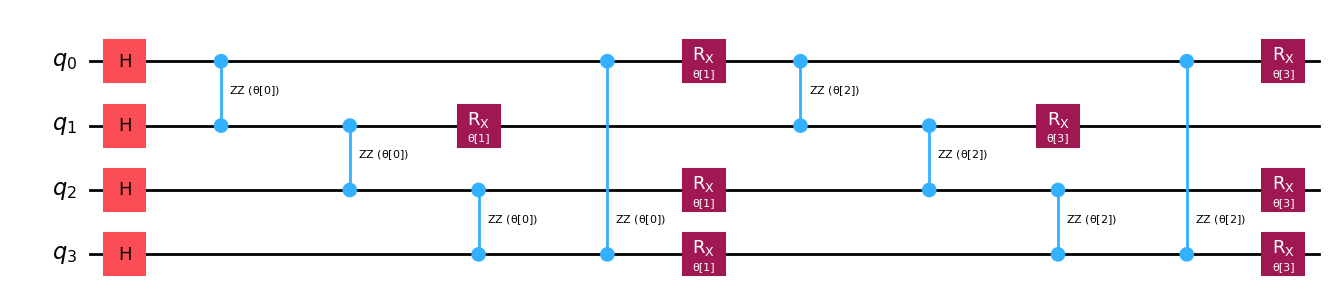

In [72]:
# Example usage:
qc, _ = circuit_HVA_TIFM(num_q, layer)
qc.draw("mpl")
# qc.draw(output="latex")

In [73]:
# weights = np.random.uniform(0, 2*np.pi, size=num_p)

# expval = expectation_loss_grad(num_q,
#                                layer,
#                                weights,
#                                circuit=circuit_HVA_TIFM,
#                                obs=tfim_op,
#                                )
# print(expval)

# expval = expectation_loss_grad(num_q,
#                                layer,
#                                weights,
#                                circuit=circuit_HVA_TIFM,
#                                obs=tfim_op,
#                                shots=1024,
#                                )
# print(expval)

# expval, grad  = expectation_loss_grad(num_q,
#                                layer,
#                                weights,
#                                circuit=circuit_HVA_TIFM,
#                                output="both",
#                                obs=tfim_op,
#                                )
# print(expval)
# print(grad)

# expval, grad  = expectation_loss_grad(num_q,
#                                layer,
#                                weights,
#                                circuit=circuit_HVA_TIFM,
#                                output="both",
#                                obs=tfim_op,
#                                shots=1024,
#                                )
# print(expval)
# print(grad)

# expval, grad  = expectation_loss_grad(num_q,
#                                layer,
#                                weights,
#                                circuit=circuit_HVA_TIFM,
#                                output="both",
#                                obs=tfim_op,
#                                shots=1024,
#                                spec_param= 0,
#                                )
# print(expval)
# print(grad)

# expval, grad  = expectation_loss_grad(num_q,
#                                layer,
#                                weights,
#                                circuit=circuit_HVA_TIFM,
#                                output="both",
#                                obs=tfim_op,
#                                shots=1024,
#                                spec_param= [0,2],
#                                )
# print(expval)
# print(grad)

In [74]:

def expectation_loss(weights):
    return expectation_loss_grad(num_q,
                                 layer,
                                 weights,
                                 circuit=circuit_HVA_TIFM,
                                 obs=tfim_op,
                                 )


def estimate_loss(weights, shots):
    return expectation_loss_grad(num_q,
                                 layer,
                                 weights,
                                 circuit=circuit_HVA_TIFM,
                                 obs=tfim_op,
                                 shots=shots)
                                 

In [75]:
# weights_dict = {}

# from algo.utils import mse

# #################### Odd layers with RZZ gates
# omegas_1 = [2]
# interp_nodes_1 = np.linspace(0, 2 * np.pi, 2 * len(omegas_1) + 1, endpoint=False)
# inverse_interp_matrix_1 = np.linalg.inv(interp_matrix(interp_nodes_1, omegas_1))
# print(f"Minimum MSE: {mse(interp_nodes_1, omegas_1)}")

# #################### Even layers with RX gates
# omegas_2 = [2]
# interp_nodes_2 = np.linspace(0, 2 * np.pi, 2 * len(omegas_2) + 1, endpoint=False)
# inverse_interp_matrix_2 = np.linalg.inv(interp_matrix(interp_nodes_2, omegas_2))
# print(f"Minimum MSE: {mse(interp_nodes_2, omegas_2)}")

# # Construct weights_dict
# weights_dict = {}
# for j in range(num_p): 
#     if j % 2 == 0:  # Odd layers with RZZ gates
#         weights_dict[f'weights_{j}'] = {
#             'omegas': omegas_1,
#             'scale_factor': 2.0,
#             'interp_nodes': interp_nodes_1,
#             'inverse_interp_matrix': inverse_interp_matrix_1,
#         }
#     elif j % 2 == 1:  # Even layers with RYY+RXX gates
#         weights_dict[f'weights_{j}'] = {
#             'omegas': omegas_2,
#             'scale_factor': 2.0,
#             'interp_nodes': interp_nodes_2,
#             'inverse_interp_matrix': inverse_interp_matrix_2,
#         }
    
# # Print example results
# print(weights_dict['weights_0'])
# # print(weights_dict['weights_1'])
# print(len(weights_dict))


In [76]:
weights_dict = {}

from algo.utils import mse

#################### Odd layers with RZZ gates
omegas_1 = [2]
interp_nodes_1 = np.linspace(0, 2 * np.pi, 2 * len(omegas_1) + 1, endpoint=False)
inverse_interp_matrix_1 = np.linalg.inv(interp_matrix(interp_nodes_1, omegas_1))
print(f"Minimum MSE: {mse(interp_nodes_1, omegas_1)}")


# Construct weights_dict
weights_dict = {}
for j in range(num_p):
    weights_dict[f'weights_{j}'] = {
        'omegas': omegas_1,
        'scale_factor': 2.0,
        'interp_nodes': interp_nodes_1,
        'inverse_interp_matrix': inverse_interp_matrix_1,
    }
    
# Print example results
print(weights_dict['weights_0'])
# print(weights_dict['weights_1'])
print(len(weights_dict))


Minimum MSE: 1.999998666667556
{'omegas': [2], 'scale_factor': 2.0, 'interp_nodes': array([0.       , 2.0943951, 4.1887902]), 'inverse_interp_matrix': array([[ 4.71404521e-01,  4.71404521e-01,  4.71404521e-01],
       [ 6.66666667e-01, -3.33333333e-01, -3.33333333e-01],
       [-5.12790050e-16, -5.77350269e-01,  5.77350269e-01]])}
4


In [77]:
# Verify if the function can be accurately interpolated by trigonometric interpolation based on omegas

from algo.utils import check_is_trigometric  # Assuming check_is_trigometric is defined in utils module
from algo.utils import filter_omegas

# Define random weights
weights = np.random.normal(0, 4 * np.pi**2, num_p)

COMPACT_OMEGAS= []
# Loop over each weight index and check trigonometric interpolation
for j in range(num_p):
    # Circuit_HEA is simple and all Hermitian generators are Y.
    omegas = weights_dict[f'weights_{j}']['omegas']  # This needs to be determined based on the circuit (i.e., parameters to test interpolation)
    
    print('\n index to check = ', j)
    print('omegas = ', omegas)
    
    opt_interp_flag = False  # Flag to indicate if optimal interpolation should be used
    
    # Call the function to check if the objective function can be interpolated using trigonometric interpolation
    estimated_coefficients = check_is_trigometric(expectation_loss, j, omegas, weights, opt_interp_flag, verbose=True)

    # compact_omegas = filter_omegas(estimated_coefficients, omegas, threshold=1e-7)

    # print('compact_omegas = ', compact_omegas)
    # COMPACT_OMEGAS.append(compact_omegas)

for i in range(len(COMPACT_OMEGAS)):
    # print('index to check = ', i)
    print('\nFINAL COMPACT OMEGAS')
    print(i, COMPACT_OMEGAS[i])



 index to check =  0
omegas =  [2]
Estimated coefficients:  [-1.37196392 -1.33876721 -1.90636279]

 index to check =  1
omegas =  [2]
Estimated coefficients:  [-2.75316348  0.53836752  1.35632653]

 index to check =  2
omegas =  [2]
Estimated coefficients:  [-3.09786796 -0.77554017  0.89299592]

 index to check =  3
omegas =  [2]
Estimated coefficients:  [-2.29359273 -1.50407983 -0.28976499]


In [78]:
# initial_weights = np.zeros(num_p) #np.ones(num_p)
initial_weights = np.random.uniform(0, 2*np.pi, size=num_p)
n_shot = 1024
print(f"Ground state energy: {ground_energy}")

Ground state energy: -4.271558410139716


In [79]:
tol=1e-2
plot_flag=True

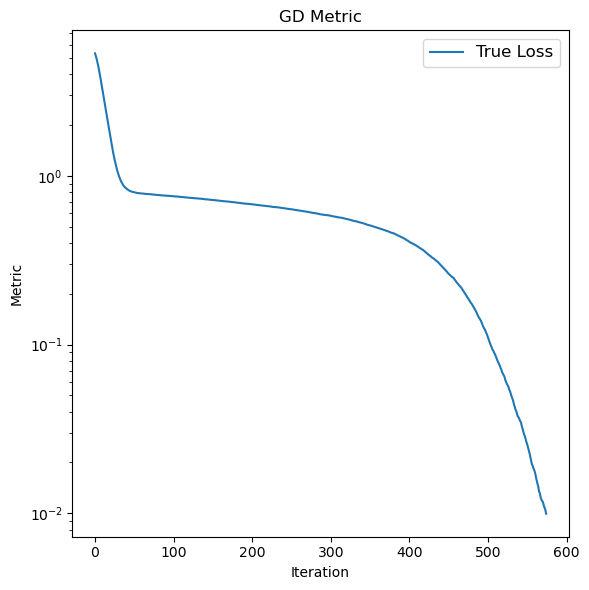

In [80]:
# Gradient Descent Optimization
from algo.gd import gd

num_iter = 15000
# Run GD
final_weights_gd, best_expected_record_value_gd, func_gd, _, metric_gd= gd(
    estimate_loss,
    expectation_loss,
    ground_energy,
    n_shot, weights_dict, initial_weights, num_iter,
    learning_rate=0.01,
    exact_mode=False,
    plot_flag=plot_flag,
    tol = tol,
)


KeyboardInterrupt: 

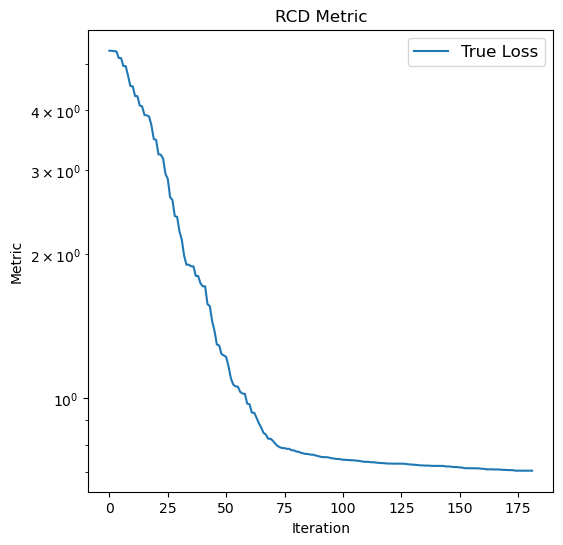

In [81]:
# RCD Optimization
from algo.rcd import rcd

num_iter = 15000
# Run RCD
final_weights_rcd, best_expected_record_value_rcd, func_rcd, _, metric_rcd = rcd(
    estimate_loss,
    expectation_loss,
    ground_energy,
    n_shot, weights_dict, initial_weights, num_iter,
    cyclic_mode=False,
    learning_rate=0.02,
    decay_step=10,
    decay_rate=-1,
    decay_threshold=1e-4,
    exact_mode=False,
    plot_flag=plot_flag,
    tol = tol,
)


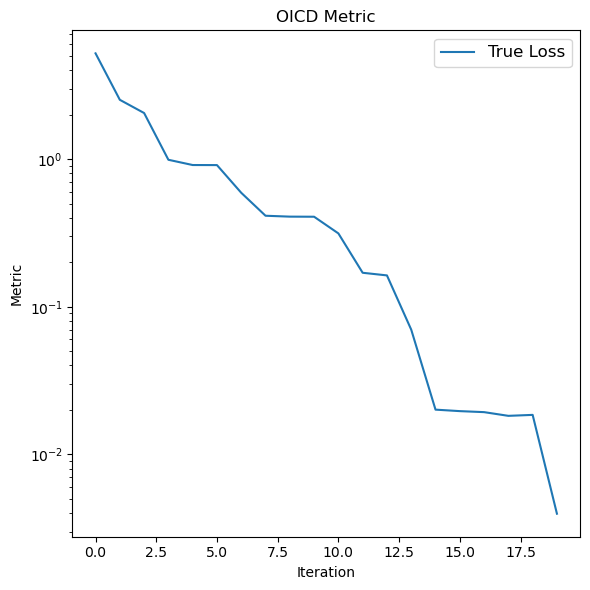

In [ ]:
# OICD Optimization
from algo.oicd import oicd

num_iter = 15000
# Run OICD
_, best_expected_record_value_oicd, func_oicd, _, metric_oicd = oicd(
    estimate_loss,
    expectation_loss,
    ground_energy,
    n_shot, weights_dict, initial_weights, num_iter,
    cyclic_mode=False,
    use_pratical_interp_flag=True,
    use_local_solvers_flag=False,
    use_global_solvers_flag = False,
    use_eigen_method_flag = True,
    # subproblem_method='BFGS',
    # subproblem_iter=None,
    use_exact_update_frequencey_1_flag = False,
    exact_mode=False, # for testing purpose, no noisy loss
    plot_flag=plot_flag,
    plot_argmin_flag=False,
    tol = tol,
)


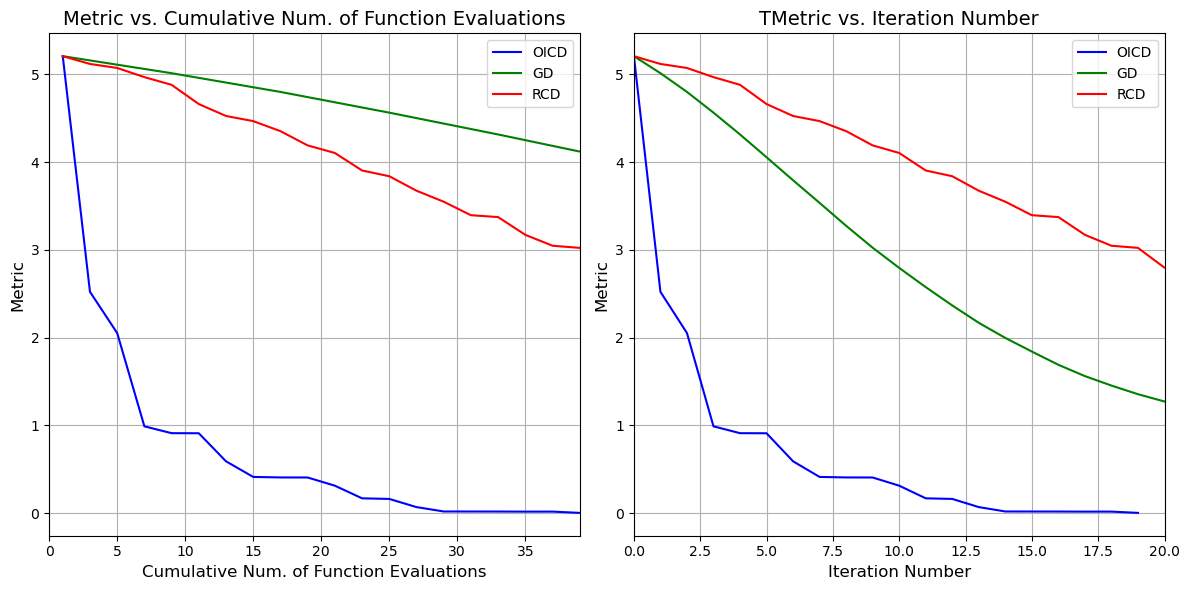

In [ ]:
# Create a 1x2 subplot layout
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First subplot: x-axis is the cumulative number of function evaluations, y-axis is the function value
axs[0].plot(func_oicd, metric_oicd, label='OICD', color='blue')
axs[0].plot(func_gd, metric_gd, label='GD', color='green')
axs[0].plot(func_rcd, metric_rcd, label='RCD', color='red')
# axs[0].axhline(y=ground_energy, color='r', linestyle='--', label='Ground Energy')

# Set labels and title for the first subplot
axs[0].set_xlabel('Cumulative Num. of Function Evaluations', fontsize=12)
axs[0].set_ylabel('Metric', fontsize=12)
# axs[0].set_yscale('log')
axs[0].set_title('Metric vs. Cumulative Num. of Function Evaluations', fontsize=14)

# Set the x-axis range
# x_range = np.average([func_oicd[-1], func_gd[-1], func_rcd[-1]])
# x_range = max(func_oicd[-1], func_gd[-1], func_rcd[-1])
# x_range = min(func_oicd[-1], func_gd[-1], func_rcd[-1])
x_range = func_oicd[-1]*1
axs[0].set_xlim(0, x_range)

# Display the legend for the first subplot
axs[0].legend()

# Second subplot: x-axis is the iteration number, y-axis is the function value
axs[1].plot(metric_oicd, label='OICD', color='blue')
axs[1].plot(metric_gd, label='GD', color='green')
axs[1].plot(metric_rcd, label='RCD', color='red')
# axs[1].axhline(y=ground_energy, color='r', linestyle='--', label='zero')

# Set labels and title for the second subplot
axs[1].set_xlabel('Iteration Number', fontsize=12)
axs[1].set_ylabel('Metric', fontsize=12)
# axs[1].set_yscale('log')
axs[1].set_title('TMetric vs. Iteration Number', fontsize=14)

# Set the x-axis range
axs[1].set_xlim(0, min(len(best_expected_record_value_oicd), len(best_expected_record_value_gd), len(best_expected_record_value_rcd)))

# Display the legend for the second subplot
axs[1].legend()

# Display grid lines
for ax in axs:
    ax.grid(True)

# Adjust the layout automatically to avoid overlapping labels between subplots
plt.tight_layout()

# Show the plot
plt.show()
